## Librairies nécessaires

In [ ]:
import numpy as np
!pip install wfdb
import wfdb
import os
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt #pour filtre du bruit

## Définitions

### Définition du SNR (Signal-to-Noise Ratio)

Le SNR est défini comme le rapport entre la puissance du signal $P_{s}$ et la puissance du bruit $P_{n}$, exprimé en décibels (dB) :

$$SNR_{dB}=10\log_{10}\left(\frac{P_{s}}{P_{n}}\right)$$

#### Puissance d'un signal

La puissance moyenne d'un signal discret $x[n]$ sur $N$ échantillons est donnée par :

$$P_{s}=\frac{1}{N}\sum_{n=1}^{N}x[n]^2$$

De même, la puissance du bruit $P_{n}$ est définie comme :

$$P_{n}=\frac{1}{N}\sum_{n=1}^{N}b[n]^2$$

où $b[n]$ est le bruit ajouté au signal.

### Calcul du niveau de bruit pour un SNR donné

Si on souhaite ajouter un bruit ayant un SNR spécifique, la puissance du bruit nécessaire est obtenue par :

$$P_{n}=\frac{P_{s}}{10^{SNR_{dB}/10}}$$

Ensuite, on génère un bruit gaussien $b[n]$ avec une variance $\sigma_{n}^2=P_{n}$(estimation de variance d'une *v.a.r* centrée).

Sources :
Signal-to-noise ratio. *Wikipedia*. , https://en.wikipedia.org/wiki/Signal-to-noise_ratio

#### Bruits dûs au signal électromyogramme EMG:
Malgré que les électrocardiographes soient conçus pour être essentiellement sensibles aux
contractions du myocarde, l’ECG peut enregistrer aussi les contractions des autres muscles
Squelettiques. En effet, Ce bruit est dû à la contraction des tissus musculaire qui est
accompagnée par une dépolarisation des cellules ce qui donne un signal électromyogramme
qui va être superposé sur le signal ECG comme **des oscillations hautes fréquences**.


Source: https://dspace.univ-eloued.dz/server/api/core/bitstreams/1e126db3-346f-4b1c-8765-4784881f2b16/content

## Fonctions utiles

In [3]:
#nouvelle version
def simulation_bbgaussien(signal, snr_db):
    """
    Ajoute du bruit gaussien à un signal pour obtenir un SNR spécifié.

    signal: signal d'origine
    snr_db: niveau de SNR souhaité en décibels
    
    return:signal bruité
    """
    N = len(signal)
    puissance_signal = np.var(signal) #puissance du signal
    puissance_bruit = puissance_signal / (10**(snr_db / 10)) #puissance du bruit nécessaire
    bruit = np.random.normal(0, np.sqrt(puissance_bruit), N) ##génération du bruit blanc gaussien
    signal_bruite = signal + bruit #signal bruité
    return signal_bruite
#source: https://www.youtube.com/watch?v=NEnRuu0WlsU

def ajout_bruit_baseline(signal, snr_db, f=0.1, Te=1000):
    """
    Simule un bruit de baseline(respiratoire) en ajoutant une basse fréquence au signal.

    f: fréquence du bruit
    Te: T d'échantillonnage
    """
    N = len(signal)
    t = np.arange(N) / Te
    bruit = np.sin(2 * np.pi * f * t) #non-stationnaire(statistiquement) 

    #ajustement du bruit en fonction du SNR
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit *= np.sqrt(puissance_bruit) / np.std(bruit)

    signal_bruite = signal + bruit
    return signal_bruite
# inspiré de https://arxiv.org/html/2502.14522v1 et stackexchange


def ajout_mouvement_electrode(signal, snr_db):
    """
    Simule un mouvement des électrodes
    """
    N = len(signal)
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit = np.cumsum(np.random.normal(0, np.sqrt(puissance_bruit), N))  #marche aléatoire
    
    #standarisation du bruit
    bruit = bruit - np.mean(bruit)  
    bruit = bruit / np.std(bruit)
    
    #if puissance_bruit*N != np.var(bruit):
    #      print(puissance_bruit)#*(N*(N-1)/2))
    #      print(np.var(bruit))
    
    #puissance_bruit = np.var(bruit)
    #bruit *= np.sqrt(puissance_bruit) / np.std(bruit)
    signal_bruite = signal + bruit
    return signal_bruite

def ajout_artefacts_musculaires(signal, snr_db, Te=1000):
    """
    Simule des artefacts musculaires en ajoutant un bruit haute fréquence au signal.
    """
    N = len(signal)
    puissance_signal = np.mean(signal ** 2)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    
    bruit = np.random.normal(0, np.sqrt(puissance_bruit), N) #génération du bruit gaussien
    nyquist = 0.5 * Te

    #filtrage pour garder les fréquences 0.5-70 Hz
    b, a = butter(2, [0.5 / nyquist, 70 / nyquist], btype='bandpass')
    bruit_filtre = filtfilt(b, a, bruit)
    
    #standarisation du bruit
    bruit_filtre = bruit_filtre - np.mean(bruit_filtre)  
    bruit_filtre = bruit_filtre / np.std(bruit_filtre)

    signal_bruite = signal + bruit_filtre
    return signal_bruite

def ajout_inference_electrique(signal, snr_db, f=50, Te=1000):
    """
    Simule un bruit de baseline(respiratoire) en ajoutant une basse fréquence au signal.

    f: 50Hz(europe)
    Te: T d'échantillonnage
    """
    N = len(signal)
    t = np.arange(N) / Te
    bruit = np.sin(2 * np.pi * f * t) # non-stationnaire(statistiquement) 

    #standarisation du bruit
    bruit = bruit - np.mean(bruit)  
    bruit = bruit / np.std(bruit)

    #ajustement du bruit en fonction du SNR
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit *= np.sqrt(puissance_bruit) / np.std(bruit)

    signal_bruite = signal + bruit
    return signal_bruite

## Exemple de bruitage d'un signal

In [7]:
fs = 500  # Sampling frequency in Hz
t = np.arange(0, 10, 1/fs)  # 10 seconds of data

ecg_signal = np.sin(2 * np.pi * 1 * t)

Sampling frequency : $f_s = 500$ \\
Time: $t \in \{0/500,1/500,..., 5000/500\}$

$$ecg.signal = sin(2 \pi t)$$


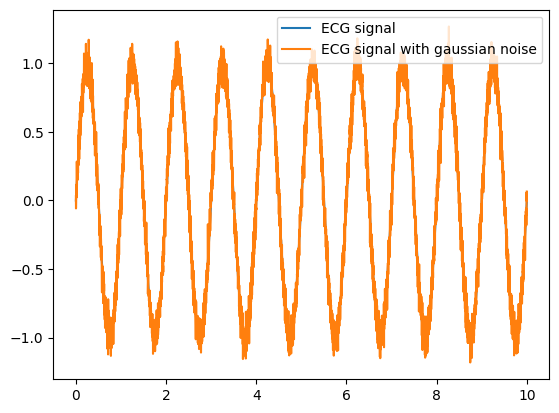

In [56]:
plt.plot(t,ecg_signal, label='ECG signal')
plt.plot(t,bb, label='ECG signal with gaussian noise')
plt.legend()

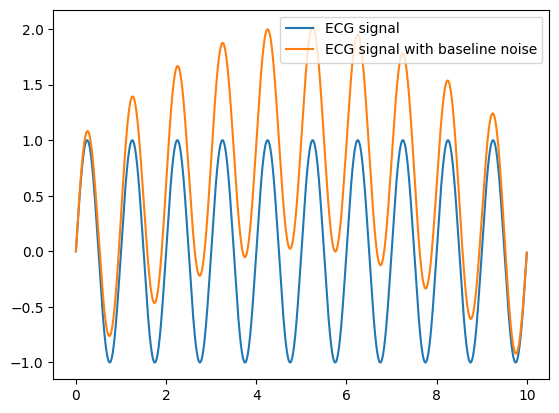

In [84]:
ecg_baseline = ajout_bruit_baseline(ecg_signal, 7)

plt.plot(t,ecg_signal, label='ECG signal')
plt.plot(t,ecg_baseline, label='ECG signal with baseline noise')
plt.legend()

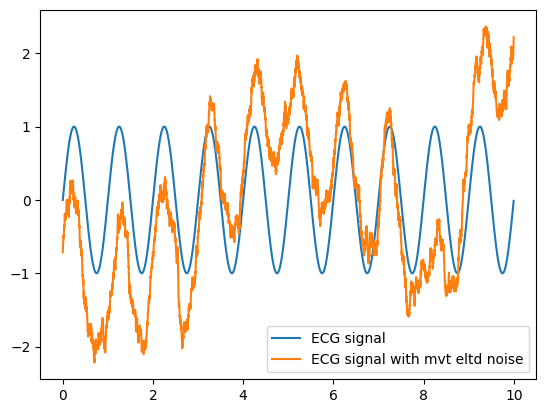

In [85]:
ecg_mvt_electrode = ajout_mouvement_electrode(ecg_signal, 10)
plt.plot(t,ecg_signal, label='ECG signal')
plt.plot(t,ecg_mvt_electrode, label='ECG signal with mvt eltd noise')
plt.legend()

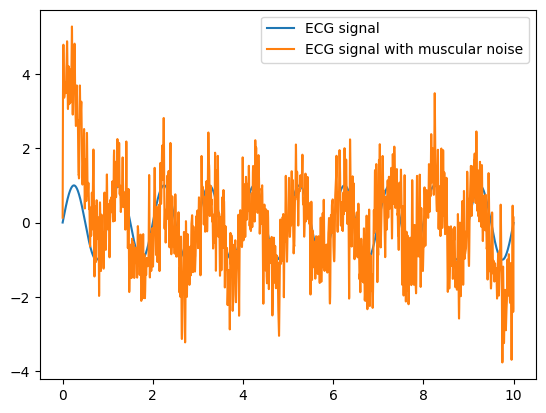

In [92]:
ecg_muscle = ajout_artefacts_musculaires(ecg_signal, 19)
plt.plot(t,ecg_signal, label='ECG signal')
plt.plot(t,ecg_muscle, label='ECG signal with muscular noise')
plt.legend()

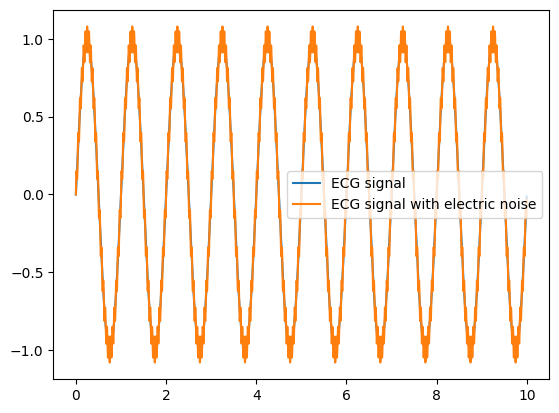

In [93]:
signal_noised = ajout_inference_electrique(ecg_signal, snr_db=22)
plt.plot(t,ecg_signal, label='ECG signal')
plt.plot(t,signal_noised, label='ECG signal with electric noise')
plt.legend()

Sources :
* https://www.youtube.com/watch?v=NEnRuu0WlsU
* (Baseline+) StackExchange [Lien](https://dsp.stackexchange.com/questions/6103/adding-noise-to-an-ecg-signal)
* Investigating the Generalizability of ECG Noise Detection Across Diverse Data Sources and Noise Types ([Lien](https://arxiv.org/html/2502.14522v1))
* ANALYSE ET SYNTHESE DES SIGNAUX ECG AUTOUR DE LA CARTE STM32F429; P53-56; [Lien](https://dspace.univ-eloued.dz/server/api/core/bitstreams/1e126db3-346f-4b1c-8765-4784881f2b16/content)
* http://dspace.univ-tlemcen.dz/bitstream/112/11338/1/Ms.EBM.Boukhobza.pdf